# Taking serial inputs

In [2]:
import serial
import time
from pqi import *
import matplotlib.pyplot as plt
import numpy as np

####
from IPython.display import clear_output
%matplotlib inline
####

ser = serial.Serial('COM9', 9600)
start_time = time.time()

alice_new = []
bob_new   = []
alice_total   = []
bob_total     = []

step = 1

try:
    while True:
        ## Run for 10 seconds
        if time.time() - start_time >= 10:
            break
        # line = ser.readline().decode('utf-8').strip()
        # alice_read, bob_read = map(int, line.split())
        
        # alice_new.append(alice_read)
        # bob_new.append(bob_read)
        # numbers.append([alice_read, bob_read])

        if time.time() - start_time >= step:


            clear_output(wait=True)

            # direct reading
            plt.figure(figsize=(5, 2))
            plt.plot(alice_new, 'r-', label="Alice", linewidth=1, alpha=0.7)
            plt.plot(alice_new, 'r.')
            plt.plot(bob_new, 'b-', label="Bob", linewidth=1, alpha=0.7)
            plt.plot(bob_new, 'b.')
            plt.legend(loc='upper right', title='RSSI readings')
            plt.show()

            # projected
            plt.figure(figsize=(5, 2))
            alice_projected = spline_projection(alice_new)
            bob_projected = spline_projection(bob_new)
            plt.plot(alice_projected, 'r--', label="Alice", linewidth=1, alpha=0.7)
            plt.plot(alice_projected, 'rx')
            plt.plot(bob_projected, 'b--', label="Bob", linewidth=1, alpha=0.7)
            plt.plot(bob_projected, 'bx')
            plt.legend(loc='upper right', title='Projected')
            plt.show()

            # quantized
            plt.figure(figsize=(5, 2))

            alice_quantized= quantization_m(alice_projected, 16)
            bob_quantized = quantization_m(bob_projected, 16)
            plt.plot(alice_quantized, 'r:', label="Alice", linewidth=1, alpha=0.7)
            plt.plot(alice_quantized, 'r3')
            plt.plot(bob_quantized, 'b:', label="Bob", linewidth=1, alpha=0.7)
            plt.plot(bob_quantized, 'b3')
            plt.legend(loc='upper right', title='Quantized')
            plt.show()

            alice_new = []
            bob_new   = []
            step += 1
        else:
            line = ser.readline().decode('utf-8').strip()
            alice_read, bob_read = map(int, line.split())

            alice_new.append(alice_read)
            bob_new.append(bob_read)

            alice_total.append(alice_read)
            bob_total.append(bob_read)

except KeyboardInterrupt:
    print("\nStopped")

# print("Collected numbers:")
# print(numbers)

# # Close the serial port
ser.close()

SerialException: could not open port 'COM9': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

In [147]:
print(alice_total)
print(bob_total)

print([[x[0], x[1]] for x in zip(alice_total, bob_total)])

[-47, -47, -43, -42, -41, -46, -42, -48, -45, -45, -45, -46, -45, -46, -47, -49, -50, -51, -48, -51, -47, -44, -44, -44, -43, -39, -38, -48, -48, -37, -39, -46, -38, -37, -36, -38, -36, -50, -45, -44, -43, -39, -37, -44, -38, -45, -36, -35, -37, -52, -37, -37, -36, -46, -46, -50, -37, -33, -39, -47, -38, -34, -38, -45, -36, -46, -37, -37, -39, -53, -52, -47, -46, -51, -52, -38, -32, -34, -41, -45, -39, -34, -32, -28, -36, -47, -33, -31, -37, -35, -26, -28, -40, -31, -27, -35, -40, -38, -35, -42, -44]
[-47, -44, -45, -44, -40, -46, -44, -47, -42, -44, -45, -44, -44, -46, -48, -50, -51, -50, -47, -50, -47, -44, -41, -43, -40, -38, -38, -48, -48, -37, -39, -46, -38, -37, -36, -37, -37, -48, -45, -41, -41, -38, -37, -40, -37, -45, -36, -35, -36, -51, -38, -37, -35, -46, -46, -50, -37, -33, -44, -47, -37, -33, -38, -44, -35, -45, -37, -37, -38, -53, -52, -48, -47, -52, -52, -37, -32, -33, -39, -45, -38, -34, -31, -28, -37, -46, -32, -31, -37, -34, -26, -27, -41, -31, -27, -35, -42, -38, -35

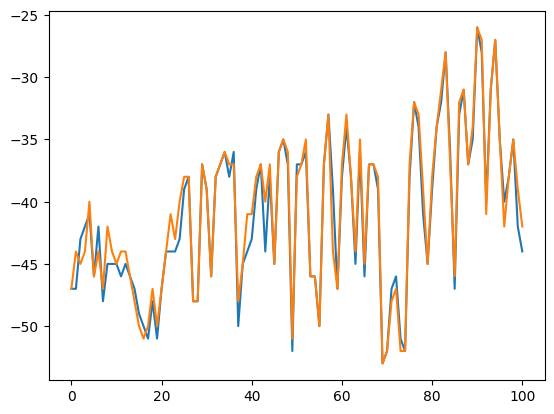

In [148]:
plt.plot(alice_total)
plt.plot(bob_total)

In [103]:
global previous_lvls
previous_lvls = []
def quantization_m(data, m):
    global previous_lvls
    data = np.array(data)
    quant_seq = []

    variance = (1/len(data)) * np.sum(data**2)
    norm_x = data/np.sqrt(variance)
    
    x_min = min(norm_x)
    x_max = max(norm_x)
    #print(x_max)
    delta = (x_max-x_min)/(m-1)
    #print((x_min-(delta/100), x_max+(delta/100), delta), norm_x)

    try:
        lvls = np.arange(x_min-0.1, x_max+0.1, delta)
        ## print(lvls, x_min, x_max)
        ## print(norm_x)
    except:
        lvls = previous_lvls # failsafe if quantization level gen. fails

    previous_lvls = lvls 
    
    for x in norm_x:
        for i in range(1,len(lvls)):
            #print(x, lvls[i-1], lvls[i], lvls)
            if(x>lvls[i-1] and x<lvls[i]):
                #print(len(lvls))
                quant_seq.append(i-1) # to starting level no.
                #print(x, lvls[i-1], lvls[i])
                break
    return quant_seq


d = [-94, -62, -32, -99, -34, -46, -34, -28]
quantization_m(d, 8)

[1, 4, 7, 0, 6, 5, 6, 7]

In [110]:
np.arange(-10-0.001, 11.00000000000005, .5)

array([-1.0001e+01, -9.5010e+00, -9.0010e+00, -8.5010e+00, -8.0010e+00,
       -7.5010e+00, -7.0010e+00, -6.5010e+00, -6.0010e+00, -5.5010e+00,
       -5.0010e+00, -4.5010e+00, -4.0010e+00, -3.5010e+00, -3.0010e+00,
       -2.5010e+00, -2.0010e+00, -1.5010e+00, -1.0010e+00, -5.0100e-01,
       -1.0000e-03,  4.9900e-01,  9.9900e-01,  1.4990e+00,  1.9990e+00,
        2.4990e+00,  2.9990e+00,  3.4990e+00,  3.9990e+00,  4.4990e+00,
        4.9990e+00,  5.4990e+00,  5.9990e+00,  6.4990e+00,  6.9990e+00,
        7.4990e+00,  7.9990e+00,  8.4990e+00,  8.9990e+00,  9.4990e+00,
        9.9990e+00,  1.0499e+01,  1.0999e+01])